In [1]:
import numpy as np
import scipy
import h5py
import matplotlib.pyplot as plt
from scipy.integrate import quad

%matplotlib inline
import datetime
import matplotlib.dates as mdates
import re
import io_utils #custom wrapper for pytables
import matplotlib as mpl
import madrigalWeb.madrigalWeb
import os
import datetime
import uncertainties 
import uncertainties.unumpy as unumpy 

import pandas as pd

In [2]:
#CHANGE ME
user_fullname = "Brian La Rosa"
user_email = "bl639@cornell.edu"
user_affiliation = "Cornell University"

maddat = madrigalWeb.madrigalWeb.MadrigalData('https://data.amisr.com/madrigal/')

In [3]:
instcodes={'PFISR':61}

In [4]:
#start time
st=datetime.datetime(2025,7,22,4,0,0)
et=datetime.datetime(2025,7,22,6,0,0)
expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30003350
realUrl: http://data.amisr.com/madrigal/showExperiment/?experiment_list=30003350
url: http://data.amisr.com/madrigal/madtoc/experiments0/2025/pfa/22jul25n
name: ISRSchl2025Grp5PFTEC.v01 - Poker Flat TEC
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2025
startmonth: 7
startday: 22
starthour: 4
startmin: 3
startsec: 42
endyear: 2025
endmonth: 7
endday: 22
endhour: 5
endmin: 59
endsec: 56
isLocal: True
madrigalUrl: http://https://data.amisr.com/madrigal
PI: Asti Bhatt
PIEmail: asti.bhatt@sri.com
uttimestamp: 1753300274
access: 0
Madrigal version: 3.4



In [5]:
# Get all the files associated with the experiment:
fileList = maddat.getExperimentFiles(expList[0].id)
for file in fileList:
    print(os.path.basename(file.name),'\tkindat:',file.kindat,'desc:',file.kindatdesc)

pfa20250722.014_ac_nenotr_01min.001.h5 	kindat: 1000201 desc: Ne From Power - Alternating Code (E-region) - 1 min
pfa20250722.014_ac_fit_01min.001.h5 	kindat: 2000201 desc: Fitted - Alternating Code (E-region) - 1 min
pfa20250722.014_ac_nenotr_03min.001.h5 	kindat: 1000203 desc: Ne From Power - Alternating Code (E-region) - 3 min
pfa20250722.014_ac_fit_03min.001.h5 	kindat: 2000203 desc: Fitted - Alternating Code (E-region) - 3 min
pfa20250722.014_ac_nenotr_05min.001.h5 	kindat: 1000205 desc: Ne From Power - Alternating Code (E-region) - 5 min
pfa20250722.014_ac_fit_05min.001.h5 	kindat: 2000205 desc: Fitted - Alternating Code (E-region) - 5 min
pfa20250722.014_ac_nenotr_10min.001.h5 	kindat: 1000210 desc: Ne From Power - Alternating Code (E-region) - 10 min
pfa20250722.014_ac_fit_10min.001.h5 	kindat: 2000210 desc: Fitted - Alternating Code (E-region) - 10 min
pfa20250722.014_ac_nenotr_15min.001.h5 	kindat: 1000215 desc: Ne From Power - Alternating Code (E-region) - 15 min
pfa20250722

In [6]:
#fileList = maddat.getExperimentFiles(expList[0].id)
opt1 = 'Fitted'
opt2 = 'F-region'
opt3 = '1 min'
bcfile=None
for file in fileList:
    if opt1 in file.kindatdesc:
        if opt2 in  file.kindatdesc:
            if opt3 in  file.kindatdesc:
                bcfile=file
                break

title = opt1 + ' '+opt2 + ' '+opt2 + ' '
filename     = bcfile.name
outfilename  = os.path.basename(bcfile.name)
result = maddat.downloadFile(filename, outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [7]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = dat['2D Parameters/ne'][:]
        outdct['dne'] = dat['2D Parameters/dne'][:]
        outdct['te'] = dat['2D Parameters/te'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

/tmp/ipykernel_556472/4022514743.py:15: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]


In [8]:
for i,d in enumerate(PFISR_data):
    print(f"{d['bid']}  {d['azm']:.2f}\t{d['elm']:.2f}")

64016  14.04	90.00
64157  -154.30	77.50
64964  -34.69	66.09
65066  75.03	65.56


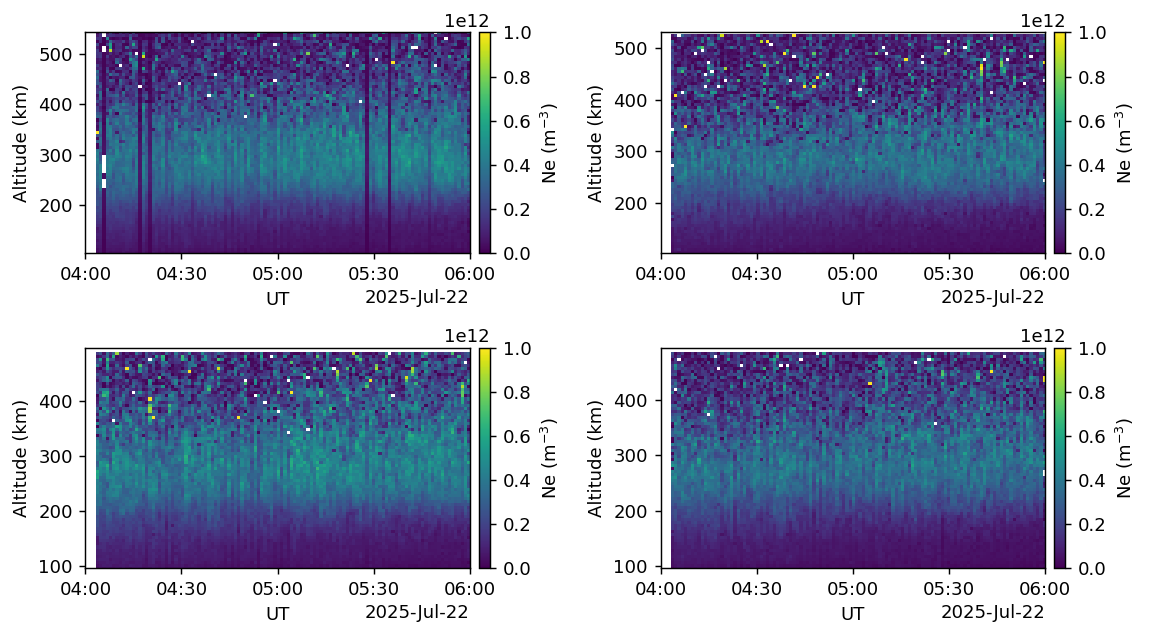

In [9]:
########### DATA ############
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2,dpi=130, figsize=(9,5))

# 'axs' is now a 2D array of Axes objects.
# You can access individual subplots using array indexing, e.g., axs[row, col].

# BEAM = 0
bdat = PFISR_data[0]
clrs = ax[0,0].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']*1e-3,bdat['ne'],vmin=0,vmax=1e12,shading='nearest')
ax[0,0].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[0,0].set_ylim([bdat['altitude'][0]*1e-3,bdat['altitude'][-1]*1e-3])
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[0,0].xaxis.set_major_locator(locator)
ax[0,0].xaxis.set_major_formatter(formatter)
ax[0,0].set_xlabel('UT')
ax[0,0].set_ylabel('Altitude (km)')
cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

# BEAM = 1
bdat = PFISR_data[1]
clrs = ax[0,1].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']*1e-3,bdat['ne'],vmin=0,vmax=1e12,shading='nearest')
ax[0,1].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[0,1].set_ylim([bdat['altitude'][0]*1e-3,bdat['altitude'][-1]*1e-3])
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[0,1].xaxis.set_major_locator(locator)
ax[0,1].xaxis.set_major_formatter(formatter)
ax[0,1].set_xlabel('UT')
ax[0,1].set_ylabel('Altitude (km)')
cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

# BEAM = 2
bdat = PFISR_data[2]
clrs = ax[1,0].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']*1e-3,bdat['ne'],vmin=0,vmax=1e12,shading='nearest')
ax[1,0].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[1,0].set_ylim([bdat['altitude'][0]*1e-3,bdat['altitude'][-1]*1e-3])
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[1,0].xaxis.set_major_locator(locator)
ax[1,0].xaxis.set_major_formatter(formatter)
ax[1,0].set_xlabel('UT')
ax[1,0].set_ylabel('Altitude (km)')
cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

# BEAM = 3
bdat = PFISR_data[3]
clrs = ax[1,1].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']*1e-3,bdat['ne'],vmin=0,vmax=1e12,shading='nearest')
ax[1,1].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[1,1].set_ylim([bdat['altitude'][0]*1e-3,bdat['altitude'][-1]*1e-3])
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[1,1].xaxis.set_major_locator(locator)
ax[1,1].xaxis.set_major_formatter(formatter)
ax[1,1].set_xlabel('UT')
ax[1,1].set_ylabel('Altitude (km)')
cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

# Savitzky-Golay filter

In [10]:
def smootherSV(Profile):
    Q1 = np.percentile(Profile, 25)
    Q3 = np.percentile(Profile, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    newProfile = np.where((Profile<upper_bound) & (Profile>lower_bound),Profile,np.percentile(Profile, 50))
    smoother = scipy.signal.savgol_filter(newProfile, window_length=20, polyorder=3, mode="nearest")
    return smoother

def FilterProfile(Profile2D):
    filtwredProfile2D = np.zeros(Profile2D.shape)
    timelen = len(Profile2D[0,:])
    for timeCol in range(timelen):
        filtwredProfile2D[:,timeCol] = smootherSV(np.nan_to_num(Profile2D[:,timeCol],copy=False))           
    return filtwredProfile2D     

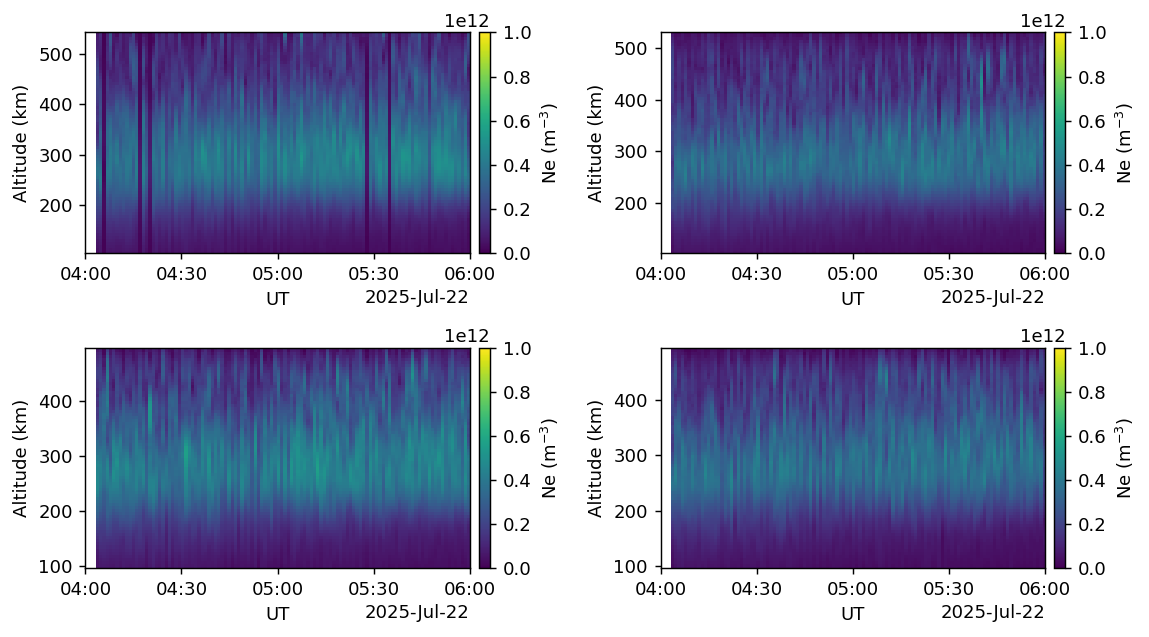

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2,dpi=130, figsize=(9,5))

# 'axs' is now a 2D array of Axes objects.
# You can access individual subplots using array indexing, e.g., axs[row, col].

# BEAM = 0
bdat = PFISR_data[0]
NeProfile = FilterProfile(bdat['ne'])
clrs = ax[0,0].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']*1e-3,NeProfile,vmin=0,vmax=1e12,shading='nearest')
ax[0,0].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[0,0].set_ylim([bdat['altitude'][0]*1e-3,bdat['altitude'][-1]*1e-3])
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[0,0].xaxis.set_major_locator(locator)
ax[0,0].xaxis.set_major_formatter(formatter)
ax[0,0].set_xlabel('UT')
ax[0,0].set_ylabel('Altitude (km)')
cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

# BEAM = 1
bdat = PFISR_data[1]
clrs = ax[0,1].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']*1e-3,FilterProfile(bdat['ne']),vmin=0,vmax=1e12,shading='nearest')
ax[0,1].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[0,1].set_ylim([bdat['altitude'][0]*1e-3,bdat['altitude'][-1]*1e-3])
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[0,1].xaxis.set_major_locator(locator)
ax[0,1].xaxis.set_major_formatter(formatter)
ax[0,1].set_xlabel('UT')
ax[0,1].set_ylabel('Altitude (km)')
cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

# BEAM = 2
bdat = PFISR_data[2]
clrs = ax[1,0].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']*1e-3,FilterProfile(bdat['ne']),vmin=0,vmax=1e12,shading='nearest')
ax[1,0].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[1,0].set_ylim([bdat['altitude'][0]*1e-3,bdat['altitude'][-1]*1e-3])
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[1,0].xaxis.set_major_locator(locator)
ax[1,0].xaxis.set_major_formatter(formatter)
ax[1,0].set_xlabel('UT')
ax[1,0].set_ylabel('Altitude (km)')
cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

# BEAM = 3
bdat = PFISR_data[3]
clrs = ax[1,1].pcolormesh(mdates.date2num(bdat['time']),bdat['altitude']*1e-3,FilterProfile(bdat['ne']),vmin=0,vmax=1e12,shading='nearest')
ax[1,1].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[1,1].set_ylim([bdat['altitude'][0]*1e-3,bdat['altitude'][-1]*1e-3])
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[1,1].xaxis.set_major_locator(locator)
ax[1,1].xaxis.set_major_formatter(formatter)
ax[1,1].set_xlabel('UT')
ax[1,1].set_ylabel('Altitude (km)')
cb=fig.colorbar(clrs, pad=0.02)
cb.set_label('Ne (m$^{-3}$)')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plot
plt.show()

In [12]:
################################ INTEGRATION FOR TEC ##############################

In [13]:
def TECIntegralWithErrors(Ne,dNe,Alt):
    timelen = len(Ne[0,:])
    NeErr = unumpy.uarray(Ne,np.abs(dNe))
    TECValues = unumpy.uarray(np.zeros(NeErr.shape[1]),np.zeros(NeErr.shape[1]))
    for timeCol in range(timelen):
        dr = Alt[1]-Alt[0]
        dummy = NeErr[:,timeCol]*dr
        TECValues[timeCol] = dummy.sum()
    return TECValues/1e16

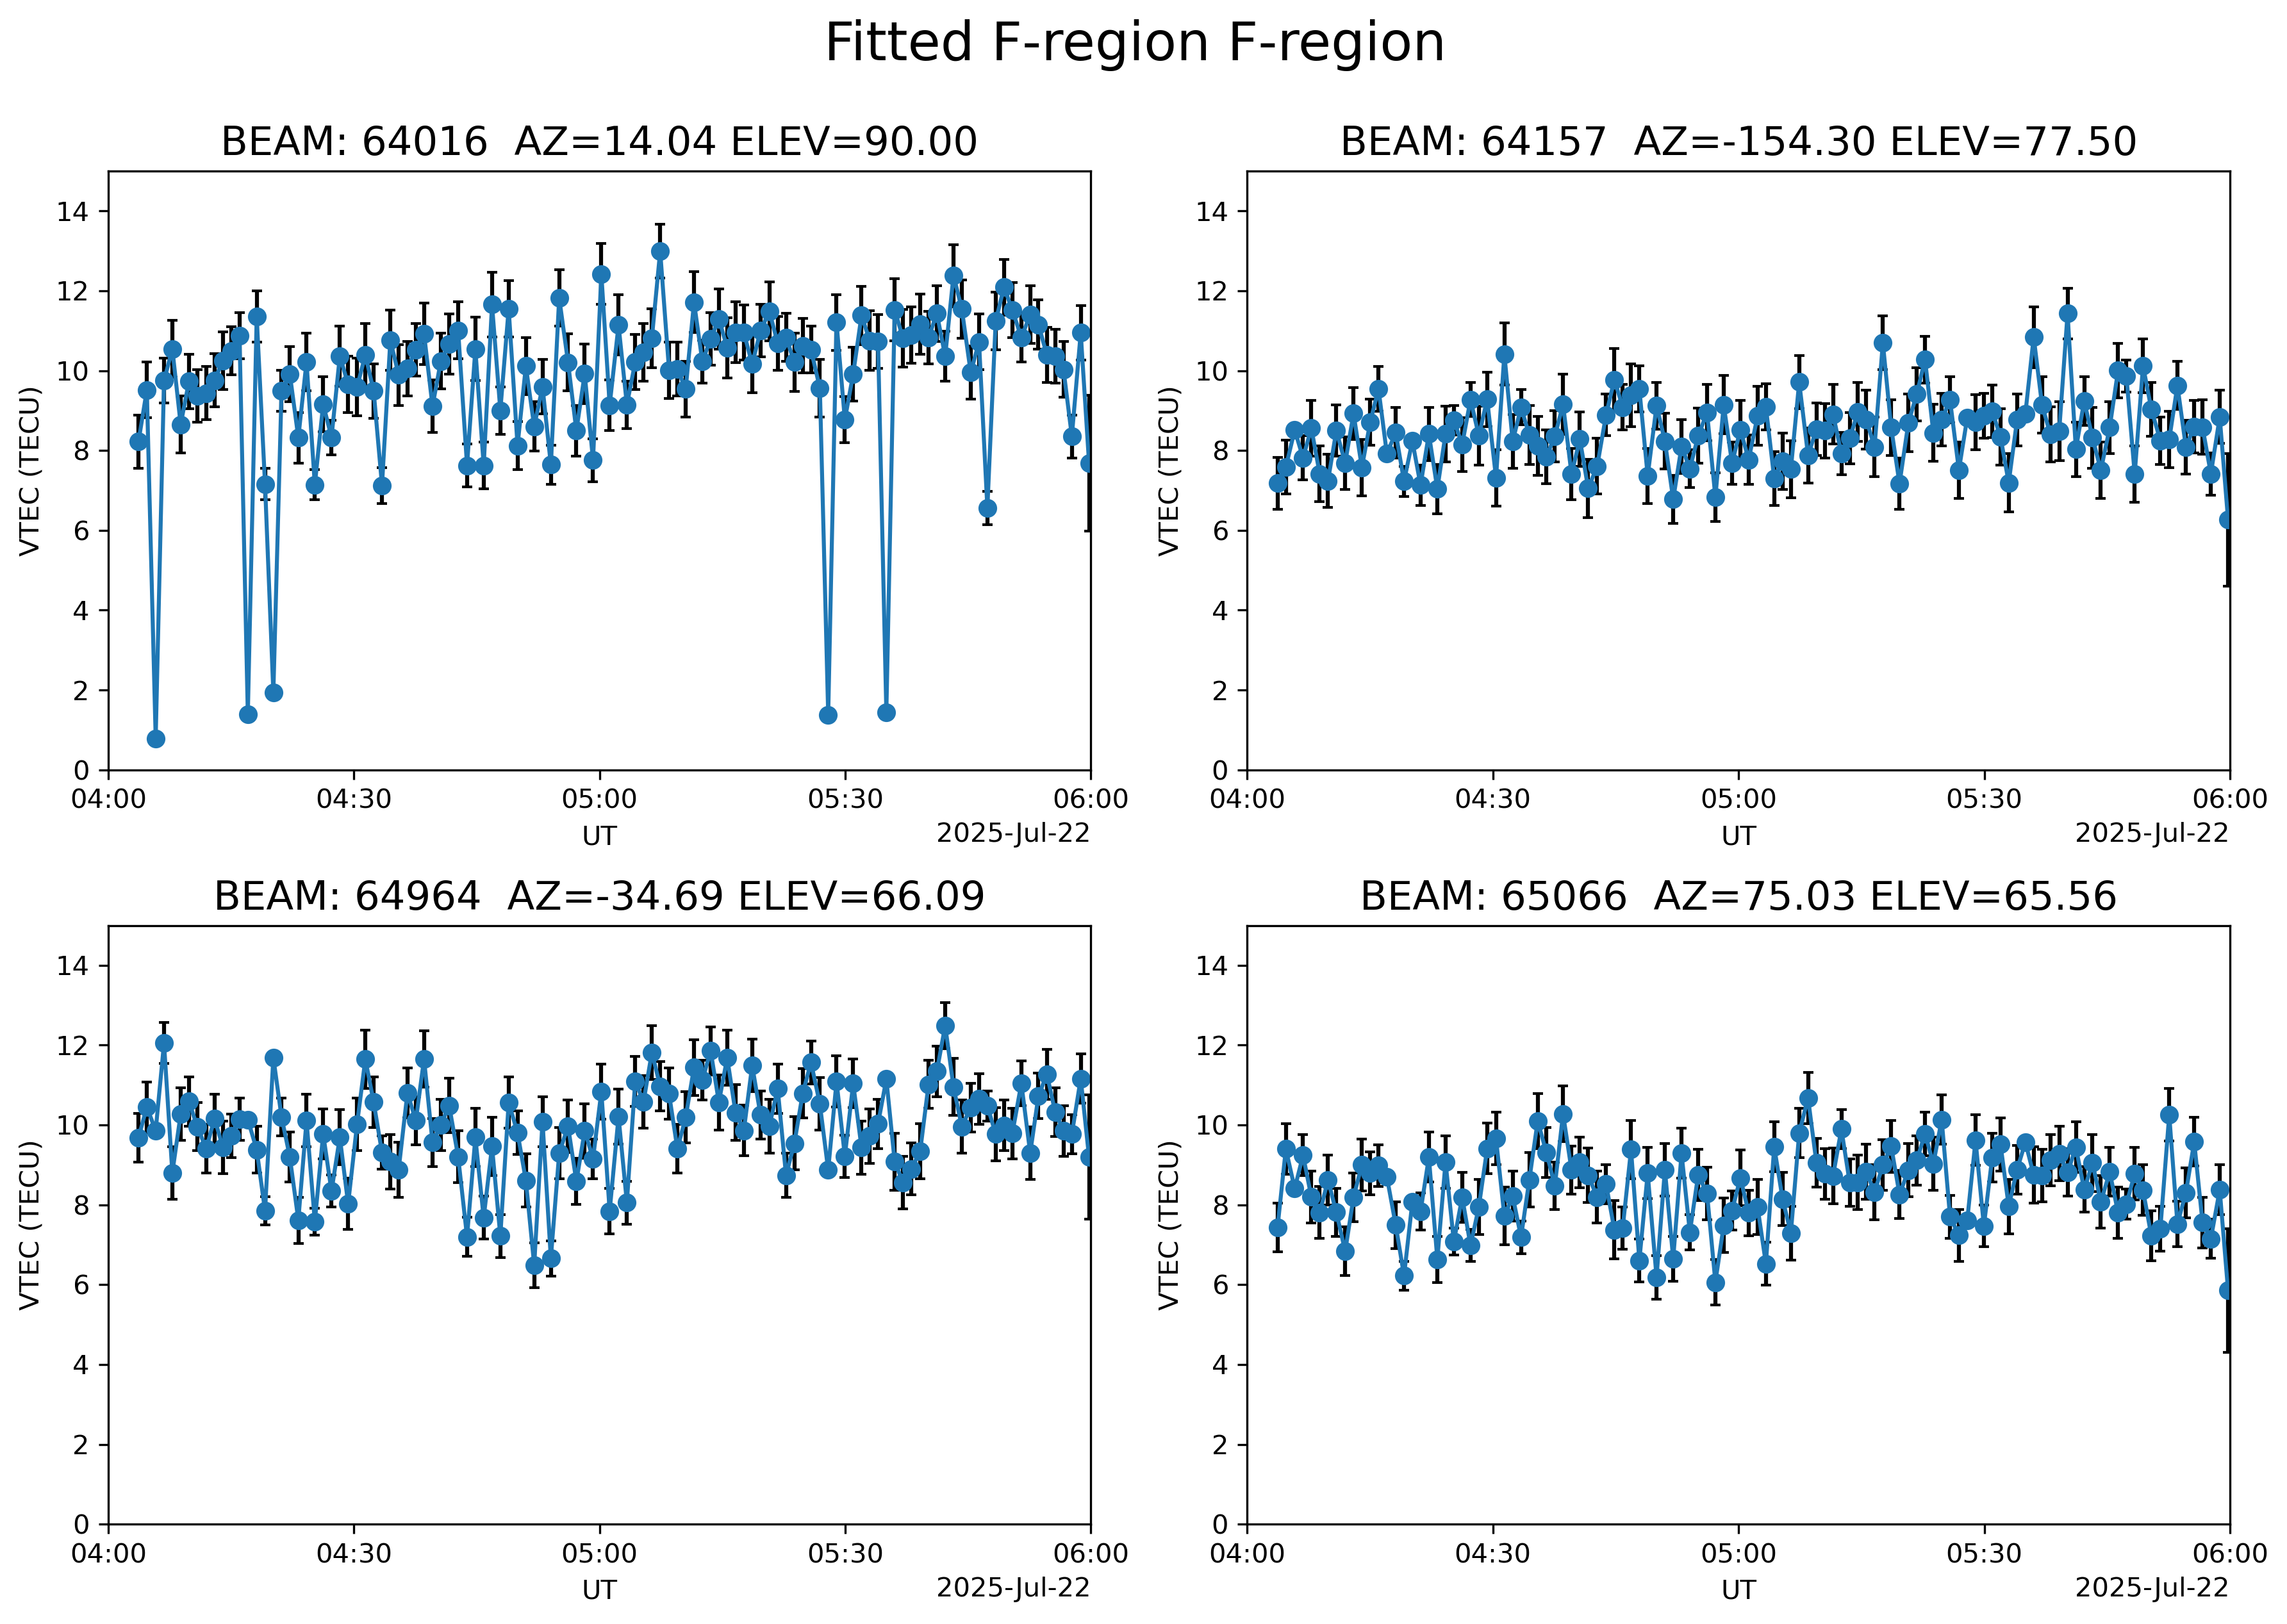

In [14]:
# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2,dpi=300, figsize=(12,8))

# 'axs' is now a 2D array of Axes objects.
# You can access individual subplots using array indexing, e.g., axs[row, col].
# 64016  14.04	90.00
# 64157  -154.30	77.50
# 64964  -34.69	66.09
# 65066  75.03	65.56

# BEAM = 0
bdat = PFISR_data[0]
NeFitted = FilterProfile(bdat['ne'])
dNeFitted = FilterProfile(bdat['dne'])
AltValues = bdat['altitude']
VTEC = TECIntegralWithErrors(NeFitted,dNeFitted,AltValues)
#ax[0,0].plot(mdates.date2num(bdat['time']),VTEC,lw=1)
ax[0,0].errorbar(mdates.date2num(bdat['time']),unumpy.nominal_values(VTEC), yerr=unumpy.std_devs(VTEC), fmt='o-', ecolor='black', capsize=2)
ax[0,0].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[0,0].set_ylim(0,15)
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[0,0].xaxis.set_major_locator(locator)
ax[0,0].xaxis.set_major_formatter(formatter)
ax[0,0].set_xlabel('UT')
ax[0,0].set_ylabel('VTEC (TECU)')
ax[0,0].set_title('BEAM: 64016  AZ=14.04 ELEV=90.00',fontsize=15)

tecdf = pd.DataFrame({"time": bdat["time"], "tec64016": unumpy.nominal_values(VTEC), "dtec64016": unumpy.std_devs(VTEC)})

# BEAM = 1
bdat = PFISR_data[1]
NeFitted = FilterProfile(bdat['ne'])
AltValues = bdat['altitude']
VTEC = TECIntegralWithErrors(NeFitted,dNeFitted,AltValues)
#ax[0,0].plot(mdates.date2num(bdat['time']),VTEC,lw=1)
ax[0,1].errorbar(mdates.date2num(bdat['time']),unumpy.nominal_values(VTEC), yerr=unumpy.std_devs(VTEC), fmt='o-', ecolor='black', capsize=2)
ax[0,1].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[0,1].set_ylim(0,15)
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[0,1].xaxis.set_major_locator(locator)
ax[0,1].xaxis.set_major_formatter(formatter)
ax[0,1].set_xlabel('UT')
ax[0,1].set_ylabel('VTEC (TECU)')
ax[0,1].set_title('BEAM: 64157  AZ=-154.30 ELEV=77.50',fontsize=15)

tecdf = pd.merge(tecdf, 
                 pd.DataFrame({"time": bdat["time"], "tec64157": unumpy.nominal_values(VTEC), "dtec64157": unumpy.std_devs(VTEC)}),
                 on="time")

# BEAM = 2
bdat = PFISR_data[2]
NeFitted = FilterProfile(bdat['ne'])
AltValues = bdat['altitude']
VTEC = TECIntegralWithErrors(NeFitted,dNeFitted,AltValues)
#ax[0,0].plot(mdates.date2num(bdat['time']),VTEC,lw=1)
ax[1,0].errorbar(mdates.date2num(bdat['time']),unumpy.nominal_values(VTEC), yerr=unumpy.std_devs(VTEC), fmt='o-', ecolor='black', capsize=2)
ax[1,0].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[1,0].set_ylim(0,15)
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[1,0].xaxis.set_major_locator(locator)
ax[1,0].xaxis.set_major_formatter(formatter)
ax[1,0].set_xlabel('UT')
ax[1,0].set_ylabel('VTEC (TECU)')
ax[1,0].set_title('BEAM: 64964  AZ=-34.69 ELEV=66.09',fontsize=15)

tecdf = pd.merge(tecdf, 
                 pd.DataFrame({"time": bdat["time"], "tec64964": unumpy.nominal_values(VTEC), "dtec64964": unumpy.std_devs(VTEC)}),
                 on="time")

# BEAM = 3
bdat = PFISR_data[3]
NeFitted = FilterProfile(bdat['ne'])
AltValues = bdat['altitude']
VTEC = TECIntegralWithErrors(NeFitted,dNeFitted,AltValues)
#ax[0,0].plot(mdates.date2num(bdat['time']),VTEC,lw=1)
ax[1,1].errorbar(mdates.date2num(bdat['time']),unumpy.nominal_values(VTEC), yerr=unumpy.std_devs(VTEC), fmt='o-', ecolor='black', capsize=2)
ax[1,1].set_xlim([mdates.date2num(datetime.datetime(2025,7,22,4,0,0)),
             mdates.date2num(datetime.datetime(2025,7,22,6,0,0))])
ax[1,1].set_ylim(0,15)
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.ConciseDateFormatter(locator)
ax[1,1].xaxis.set_major_locator(locator)
ax[1,1].xaxis.set_major_formatter(formatter)
ax[1,1].set_xlabel('UT')
ax[1,1].set_ylabel('VTEC (TECU)')
ax[1,1].set_title('BEAM: 65066  AZ=75.03 ELEV=65.56',fontsize=15)

tecdf = pd.merge(tecdf, 
                 pd.DataFrame({"time": bdat["time"], "tec65066": unumpy.nominal_values(VTEC), "dtec65066": unumpy.std_devs(VTEC)}),
                 on="time")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.suptitle(title,fontsize=20, y=1.05)

# Display the plot
plt.show()

In [17]:
# save tec dataframe as csv

tecdf.to_csv("data/pfisr_tec_filtered.csv", index=False)